# Lab 2 - Part B : The Global Race for AI Dominance and Its Implications

Last lab, we just had a glimpse of the AI landscape by looking at the AI patents provided by [USPTO](https://www.uspto.gov/ip-policy/economic-research/research-datasets/artificial-intelligence-patent-dataset). However, we did not link the patents to the companies that filed them. In this lab, we will look at the companies that are leading the AI race.


In [1]:
library(pacman)
# vtree: sudo apt-get install libcairo2-dev librsvg2-dev
# https://yulab-smu.top/treedata-book/index.html
p_load(readxl, stringr, data.table, magrittr, ggplot2, SPARQL,
        eurostat, XML, RCurl, knitr, vtree, pheatmap)

# color palette
gray_scale <- c('#F3F4F8','#D2D4DA', '#B3B5BD', 
                '#9496A1', '#7d7f89', '#777986', 
                '#656673', '#5B5D6B', '#4d505e',
                '#404352', '#2b2d3b', '#282A3A',
                '#1b1c2a', '#191a2b',
                '#141626', '#101223')

ft_palette <- c('#990F3D', '#0D7680', '#0F5499', '#262A33', '#FFF1E5')

ft_contrast <- c('#F83', '#00A0DD', '#C00', '#006F9B', '#F2DFCE', '#FF7FAA',
                 '#00994D', '#593380')

peep_head <- function(dt, n = 5) {
    dt %>%
        head(n) %>%
        kable()
}

peep_sample <- function(dt, n = 5) {
    dt %>%
        .[sample(.N, n)] %>%
        kable()
}

peep_tail <- function(dt, n = 5) {
    dt %>%
        tail(n) %>%
        kable()
}

In [2]:
aipatents <- fread(cmd = 'unzip -p ../data/ai_model_predictions.tsv.zip ai_model_predictions.tsv')

## AI patents from 2012 to 2016

To start with, we will use the same dataset that we used in the last lab and again will look at the AI patents from 2012 to 2016. To link the dataset, we will download the data from
the following resources:

- dataset download page: https://patentsview.org/download/data-download-tables
- dataset documentation: https://patentsview.org/download/data-download-dictionary
- dataset model overview: https://s3.amazonaws.com/community.patentsview.org/PatentsView+Data+Logic+Diagram+FINAL.jpg

The main dataset we will use is `g_assignee_disambiguated`. Please read this from [ChatGPT](https://chat.openai.com/share/10f3c719-a844-4ae7-aed9-63d388bed13e) to learn the difference
between applicant and assignee.

In [3]:
# only focus on patents from 2012 to 2016
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c('doc_id', 'appl_id', 'pub_dt', 
                            grep('predict50', names(.), value = TRUE))] %>%
    # get year from pub_dt, pub_dt is IDate
    .[, pub_year := as.numeric(format(pub_dt, '%Y'))] %>%
    .[pub_year >= 2012 & pub_year <=2016] %>%
    unique(by = 'doc_id') -> aipatents_2012_2016

In [18]:
str(aipatents_2012_2016)

Classes ‘data.table’ and 'data.frame':	205185 obs. of  13 variables:
 $ doc_id            : chr  "8650542" "8346687" "8489524" "9213939" ...
 $ appl_id           : chr  "13072165" "12560921" "13084692" "13785216" ...
 $ pub_dt            : IDate, format: "2014-02-11" "2013-01-01" ...
 $ predict50_any_ai  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ predict50_ml      : int  0 0 1 1 0 0 0 0 1 1 ...
 $ predict50_evo     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_nlp     : int  1 0 0 0 0 0 0 0 0 0 ...
 $ predict50_speech  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_vision  : int  0 1 0 0 1 0 0 1 1 0 ...
 $ predict50_kr      : int  1 1 1 1 1 1 1 0 1 0 ...
 $ predict50_planning: int  1 0 1 1 0 0 0 0 1 0 ...
 $ predict50_hardware: int  1 1 0 1 1 0 0 0 1 0 ...
 $ pub_year          : num  2014 2013 2013 2015 2012 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
assignee <- fread(cmd = "unzip -p ../data/g_assignee_disambiguated.tsv.zip g_assignee_disambiguated.tsv")

In [11]:
str(assignee)

Classes ‘data.table’ and 'data.frame':	8024360 obs. of  8 variables:
 $ patent_id                              : chr  "4488683" "5856666" "5204210" "5302149" ...
 $ assignee_sequence                      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ assignee_id                            : chr  "dbc3c0e0-4e68-4959-ba5b-74c7910e2247" "529d06ec-c25c-405b-a2e2-366ee31e4a6d" "65a958d3-c7ac-424c-9f8d-7b9767b0a28f" "5d2d4857-9df8-4c18-919d-1311d3a1cb85" ...
 $ disambig_assignee_individual_name_first: chr  "" "" "" "" ...
 $ disambig_assignee_individual_name_last : chr  "" "" "" "" ...
 $ disambig_assignee_organization         : chr  "Metal Works Ramat David" "U.S. Philips Corporation" "Xerox Corporation" "Commonwealth Scientific and Industrial Research Organisation" ...
 $ assignee_type                          : int  3 2 2 7 3 3 3 3 2 3 ...
 $ location_id                            : chr  "50dc5d46-16c8-11ed-9b5f-1234bde3cd05" "92237ca2-16c8-11ed-9b5f-1234bde3cd05" "0cd1998f-16c8-11ed-9b5f-1234bde3cd05

## Let's validate the dataset

We have `patent_id` from the `assignee` dataset and `doc_id` from the `aipatents` dataset.
Before we link the datasets, we need to make sure that those two IDs are indeed referring
to the same patent.

In [12]:
head(assignee)

patent_id,assignee_sequence,assignee_id,disambig_assignee_individual_name_first,disambig_assignee_individual_name_last,disambig_assignee_organization,assignee_type,location_id
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
4488683,0,dbc3c0e0-4e68-4959-ba5b-74c7910e2247,,,Metal Works Ramat David,3,50dc5d46-16c8-11ed-9b5f-1234bde3cd05
5856666,0,529d06ec-c25c-405b-a2e2-366ee31e4a6d,,,U.S. Philips Corporation,2,92237ca2-16c8-11ed-9b5f-1234bde3cd05
5204210,0,65a958d3-c7ac-424c-9f8d-7b9767b0a28f,,,Xerox Corporation,2,0cd1998f-16c8-11ed-9b5f-1234bde3cd05
5302149,1,5d2d4857-9df8-4c18-919d-1311d3a1cb85,,,Commonwealth Scientific and Industrial Research Organisation,7,4d36742f-16c8-11ed-9b5f-1234bde3cd05
D397841,0,54e9cc17-bcbd-43c8-9ee1-54063f734f3c,,,adidas AG,3,280c9de4-16c8-11ed-9b5f-1234bde3cd05
11652542,0,6760fcf0-001d-41bc-b873-4a05b0fb0e6d,,,"MITSUBISHI HEAVY INDUSTRIES, LTD.",3,42f90495-16c8-11ed-9b5f-1234bde3cd05


In [14]:
set.seed(666)
aipatents_2012_2016 %>%
    .[sample(.N, 5)] %>%
    head()

doc_id,appl_id,pub_dt,predict50_any_ai,predict50_ml,predict50_evo,predict50_nlp,predict50_speech,predict50_vision,predict50_kr,predict50_planning,predict50_hardware,pub_year
<chr>,<chr>,<IDate>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
8352881,11683487,2013-01-08,1,0,0,0,0,0,0,1,1,2013
9442769,13250251,2016-09-13,1,0,0,0,0,0,1,1,1,2016
8565002,13465889,2013-10-22,1,0,0,0,0,0,0,0,1,2013
9256406,14600529,2016-02-09,1,0,0,1,0,0,1,1,1,2016
9272219,14681433,2016-03-01,1,0,0,0,0,0,1,0,0,2016


In [16]:
# check for the first patent - doc_id: 8352881
assignee %>%
    .[patent_id == '8352881']

patent_id,assignee_sequence,assignee_id,disambig_assignee_individual_name_first,disambig_assignee_individual_name_last,disambig_assignee_organization,assignee_type,location_id
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
8352881,0,cb9bacc2-043c-4371-838f-64b66dd6e6aa,,,International Business Machines Corporation,2,0e228f17-16c8-11ed-9b5f-1234bde3cd05


If you follow [this page](https://worldwide.espacenet.com/searchResults?ST=singleline&locale=en_EP&submitted=true&DB=&query=8352881), then you can see that the patent with `patent_id` 8352881 is indeed the same as the patent with `doc_id` 8352881 from the `aipatents` dataset.

## Let's link the datasets now

We will link the datasets using the `patent_id` and `doc_id` fields. We will use the `patent_id` from the `assignee` dataset and `doc_id` from the `aipatents` dataset.

Linking the datasets could be tricky no matter what kind of programming language you use. However, `data.table` has a very efficient way to do this. We will use `data.table` to link the datasets. To linked the dataset, we need to tell `data.table`:

- what are the columns we want to join on
- what are the ids we have to match

In [19]:
# let's join the two tables
assignee[aipatents_2012_2016, on = c('patent_id' = 'doc_id')] %>%
    .[sample(.N, 5)] %>%
    head()

patent_id,assignee_sequence,assignee_id,disambig_assignee_individual_name_first,disambig_assignee_individual_name_last,disambig_assignee_organization,assignee_type,location_id,appl_id,pub_dt,predict50_any_ai,predict50_ml,predict50_evo,predict50_nlp,predict50_speech,predict50_vision,predict50_kr,predict50_planning,predict50_hardware,pub_year
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<IDate>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
9251717,NA,NA,NA,NA,NA,NA,NA,13674490,2016-02-02,1,0,0,1,1,0,0,1,1,2016
9070127,0,c9048269-66a2-4d23-a214-8577b65ae897,,,"MASTERCARD MOBILE TRANSACTIONS SOLUTIONS, INC.",2,0d13c90c-16c8-11ed-9b5f-1234bde3cd05,13292753,2015-06-30,1,0,0,0,0,0,0,1,0,2015
9152786,0,22be0f48-1066-4945-b880-2f86d7daf160,,,TENCENT TECHNOLOGY (SHENZHEN) COMPANY LIMITED,3,97056a3a-16c8-11ed-9b5f-1234bde3cd05,14079589,2015-10-06,1,0,0,1,0,0,1,1,1,2015
8341601,0,cb9bacc2-043c-4371-838f-64b66dd6e6aa,,,International Business Machines Corporation,2,0e228f17-16c8-11ed-9b5f-1234bde3cd05,12419988,2012-12-25,1,0,0,0,0,0,1,1,0,2012
9361879,0,41f6d533-cbc6-490e-bed4-a68cbf8e8e83,,,NEXIDIA INC.,2,ec2f0cf3-16c7-11ed-9b5f-1234bde3cd05,12391395,2016-06-07,1,0,1,1,1,1,1,1,1,2016


In [5]:
assignee[aipatents_2012_2016, on = c('patent_id' = 'doc_id')] -> assignee_aipatents

In [21]:
str(assignee_aipatents)

Classes ‘data.table’ and 'data.frame':	209595 obs. of  20 variables:
 $ patent_id                              : chr  "8650542" "8346687" "8489524" "9213939" ...
 $ assignee_sequence                      : int  0 0 0 0 0 0 0 0 0 NA ...
 $ assignee_id                            : chr  "6d1e3fdd-e6fb-4dbb-a0d6-c7954734a846" "fb2c28d1-e0d2-442c-9347-bfa624c4015a" "1b6ad260-cab0-4148-8743-3a4315564814" "615927af-793a-496c-8af5-2c7731b0960d" ...
 $ disambig_assignee_individual_name_first: chr  "" "" "" "" ...
 $ disambig_assignee_individual_name_last : chr  "" "" "" "" ...
 $ disambig_assignee_organization         : chr  "The MathWorks, Inc." "KDDI CORPORATION" "SIEMENS AKTIENGESELLSCHAFT" "Callahan Cellular L.L.C." ...
 $ assignee_type                          : int  2 3 3 2 3 2 3 3 2 NA ...
 $ location_id                            : chr  "bb6db1a0-16c7-11ed-9b5f-1234bde3cd05" "42f90495-16c8-11ed-9b5f-1234bde3cd05" "08f29235-16c8-11ed-9b5f-1234bde3cd05" "047210f8-16c8-11ed-9b5f-1234bde3cd

In [25]:
# check number of no-matches, meaning 'assignee_id' is NA

assignee_aipatents %>%
    .[is.na(assignee_id)] %>%
    nrow() / nrow(assignee_aipatents) * 100

[1] 3.585486

The above code shows that we have around 3.6% of the patents that are not linked. We will remove those patents from the dataset. Since the share of the unlinked patents is very low, we can safely remove them.

In [6]:
assignee_aipatents %>%
    .[!is.na(assignee_id)] -> patents_with_assignee

str(patents_with_assignee)

Classes ‘data.table’ and 'data.frame':	202080 obs. of  20 variables:
 $ patent_id                              : chr  "8650542" "8346687" "8489524" "9213939" ...
 $ assignee_sequence                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ assignee_id                            : chr  "6d1e3fdd-e6fb-4dbb-a0d6-c7954734a846" "fb2c28d1-e0d2-442c-9347-bfa624c4015a" "1b6ad260-cab0-4148-8743-3a4315564814" "615927af-793a-496c-8af5-2c7731b0960d" ...
 $ disambig_assignee_individual_name_first: chr  "" "" "" "" ...
 $ disambig_assignee_individual_name_last : chr  "" "" "" "" ...
 $ disambig_assignee_organization         : chr  "The MathWorks, Inc." "KDDI CORPORATION" "SIEMENS AKTIENGESELLSCHAFT" "Callahan Cellular L.L.C." ...
 $ assignee_type                          : int  2 3 3 2 3 2 3 3 2 3 ...
 $ location_id                            : chr  "bb6db1a0-16c7-11ed-9b5f-1234bde3cd05" "42f90495-16c8-11ed-9b5f-1234bde3cd05" "08f29235-16c8-11ed-9b5f-1234bde3cd05" "047210f8-16c8-11ed-9b5f-1234bde3cd05

## Who are the top companies

In [7]:
patents_with_assignee %>%
    .[, .N, by = c('assignee_id', 'disambig_assignee_organization')] %>%
    .[order(-N)] %>%
    head(30)

assignee_id,disambig_assignee_organization,N
<chr>,<chr>,<int>
cb9bacc2-043c-4371-838f-64b66dd6e6aa,International Business Machines Corporation,17371
d39048d1-c426-4ed2-81a0-0aabe1a2bbe7,Google LLC,7273
a1927a04-3445-44f5-9c23-0a3dba0793ca,Microsoft Corporation,5643
74b22e46-0033-4c29-9608-cf60c2124be8,"Samsung Display Co., Ltd.",3063
b63a5904-38e4-4aae-a55a-d88d38aa4f72,"Microsoft Technology Licensing, LLC",2707
e784f56b-4e29-474d-85f4-10da789716c7,Apple Inc.,2666
a2327c11-d70e-427b-ac63-8cdfa8bd8301,"Amazon Technologies, Inc.",2569
74d4f6ff-49f1-44d2-8314-f394f39b1ac4,CANON KABUSHIKI KAISHA,2184
0dcfbd03-41ee-4475-8474-6779b5948a78,SONY CORPORATION,2108


In [10]:
patents_with_assignee %>%
    # us firm
    .[assignee_type == 2] %>%
    .[, .N, by = c('assignee_id', 'disambig_assignee_organization')] %>%
    .[order(-N)] %>%
    head(10)

assignee_id,disambig_assignee_organization,N
<chr>,<chr>,<int>
cb9bacc2-043c-4371-838f-64b66dd6e6aa,International Business Machines Corporation,17371
d39048d1-c426-4ed2-81a0-0aabe1a2bbe7,Google LLC,7273
a1927a04-3445-44f5-9c23-0a3dba0793ca,Microsoft Corporation,5643
b63a5904-38e4-4aae-a55a-d88d38aa4f72,"Microsoft Technology Licensing, LLC",2707
e784f56b-4e29-474d-85f4-10da789716c7,Apple Inc.,2666
a2327c11-d70e-427b-ac63-8cdfa8bd8301,"Amazon Technologies, Inc.",2569
19631397-e27c-4b25-989b-dbf736311f3c,QUALCOMM Incorporated,2075
9407ac39-e208-4171-9508-731f436be923,Intel Corporation,1970
7baa8688-f6a4-4b26-bde4-61786f6dae06,Oracle International Corporation,1929


In [13]:
patents_with_assignee %>%
    # foreign firm
    .[assignee_type == 3] %>%
    .[, .N, by = c('assignee_id', 'disambig_assignee_organization')] %>%
    .[order(-N)] %>%
    head(10)

assignee_id,disambig_assignee_organization,N
<chr>,<chr>,<int>
74b22e46-0033-4c29-9608-cf60c2124be8,"Samsung Display Co., Ltd.",3063
74d4f6ff-49f1-44d2-8314-f394f39b1ac4,CANON KABUSHIKI KAISHA,2184
0dcfbd03-41ee-4475-8474-6779b5948a78,SONY CORPORATION,2108
9eb71de6-7165-47b4-839c-ce389eb7703f,SAP AG,1333
23124361-ee55-44b1-9be2-7df40008f4b5,FUJITSU LIMITED,1259
1b6ad260-cab0-4148-8743-3a4315564814,SIEMENS AKTIENGESELLSCHAFT,1238
38025fe3-ac5d-42a5-9cfd-b751e59f7f8b,KABUSHIKI KAISHA TOSHIBA,1071
660c3206-a0e6-4e4c-8131-5937bcf4c68b,Telefonaktiebolaget LM Ericsson (Publ),1020
d446c3a1-4982-4a7d-bfde-95a401a73c11,SAP SE,890


## Firm patents distribution in terms of technology

Now, we will look at the distribution of the patents in terms of technology, such as
'who are top firms that are focusing on computer vision, NLP, etc.'.

In [19]:
patents_with_assignee %>%
    # choose all columns except column 2, 4, 5, 8, 10, 11
    .[, .SD, .SDcols = -c(2, 4, 5, 8, 10, 11)] %>%
    # wide to long for column names that include 'predict50'
    melt(measure = patterns('predict50'), variable.name = "ai_category",
                                          value.name = "ai_category_binary") %>%
    head()

patent_id,assignee_id,disambig_assignee_organization,assignee_type,appl_id,pub_year,ai_category,ai_category_binary
<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<fct>,<int>
8650542,6d1e3fdd-e6fb-4dbb-a0d6-c7954734a846,"The MathWorks, Inc.",2,13072165,2014,predict50_ml,0
8346687,fb2c28d1-e0d2-442c-9347-bfa624c4015a,KDDI CORPORATION,3,12560921,2013,predict50_ml,0
8489524,1b6ad260-cab0-4148-8743-3a4315564814,SIEMENS AKTIENGESELLSCHAFT,3,13084692,2013,predict50_ml,1
9213939,615927af-793a-496c-8af5-2c7731b0960d,Callahan Cellular L.L.C.,2,13785216,2015,predict50_ml,1
8321146,0dcfbd03-41ee-4475-8474-6779b5948a78,SONY CORPORATION,3,12544751,2012,predict50_ml,0
8494785,fa32876b-9caf-4441-b723-96a4804d7e30,Phthisis Diagnostics Corporation,2,12870481,2013,predict50_ml,0


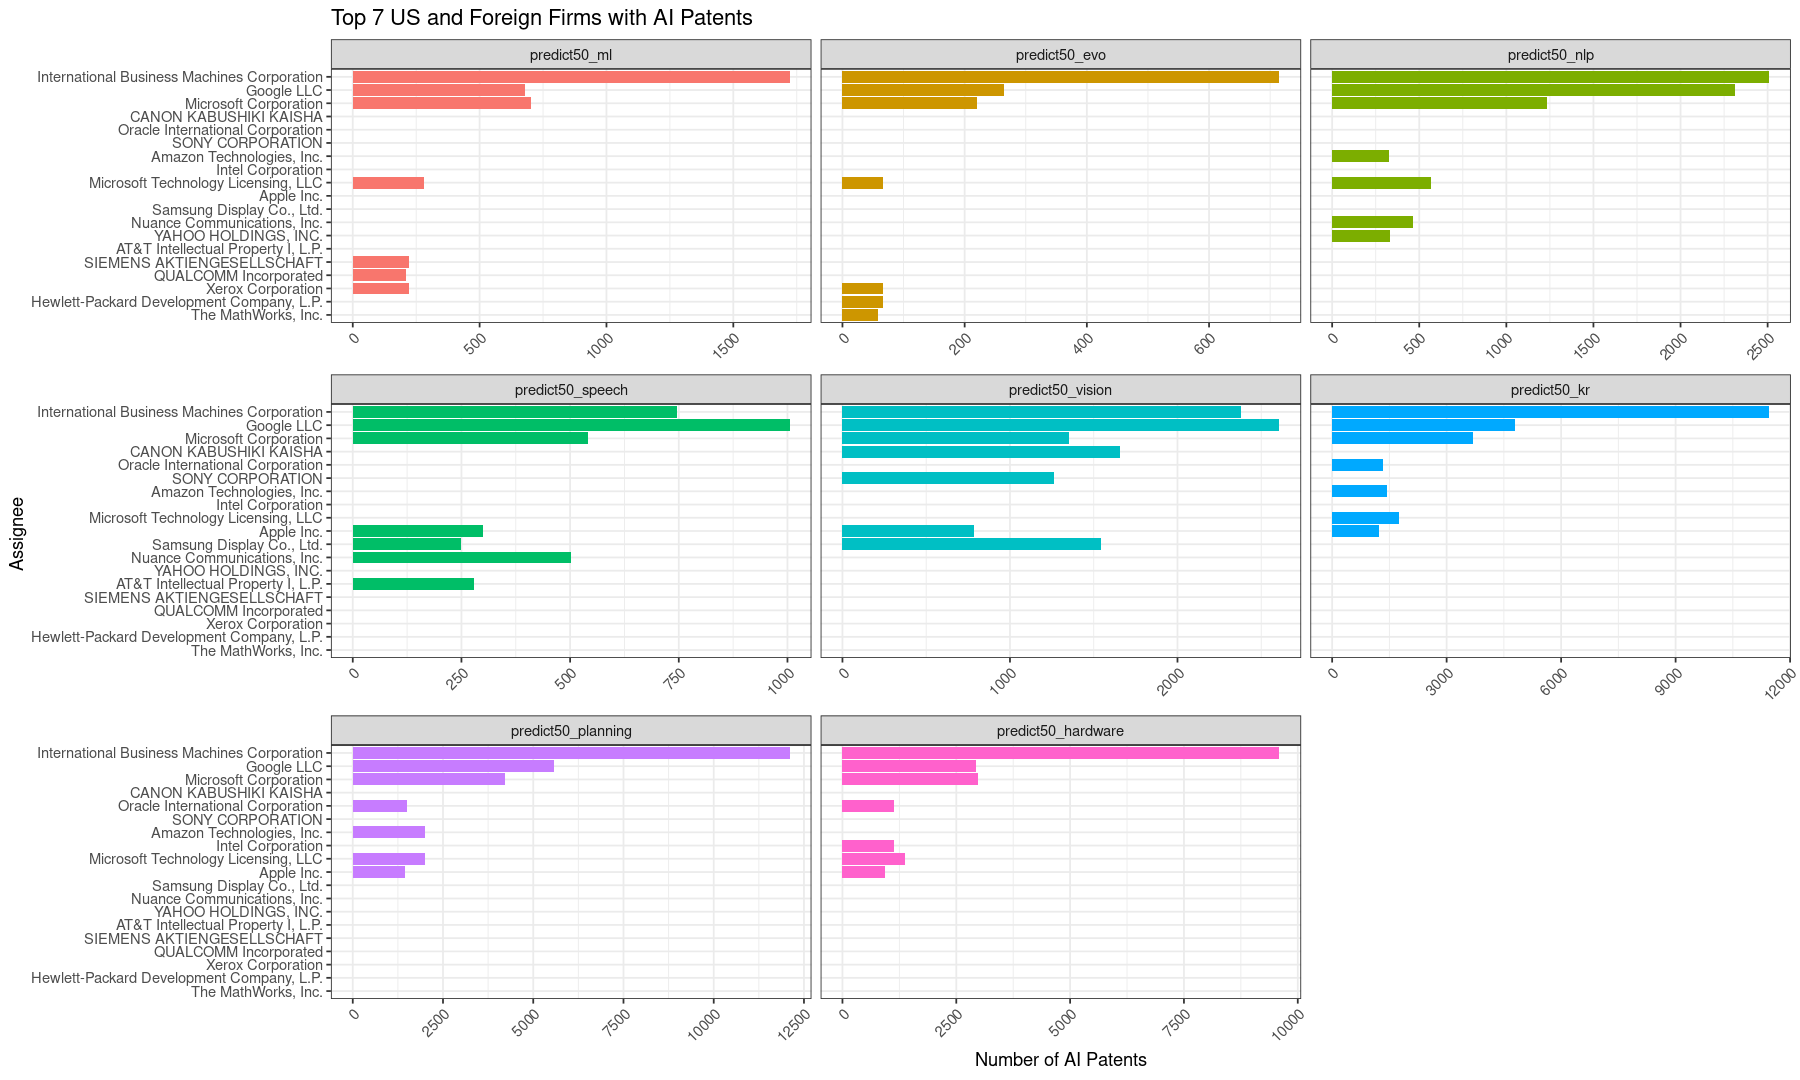

In [35]:
options(repr.plot.width = 15, repr.plot.height = 9)
patents_with_assignee %>%
    # only focus on us and foreign firms
    .[assignee_type %in% c(2, 3)] %>%
    # choose all columns except column 2, 4, 5, 8, 10, 11
    .[, .SD, .SDcols = -c(2, 4, 5, 8, 10, 11)] %>%
    # wide to long for column names that include 'predict50'
    melt(measure = patterns('predict50'), variable.name = "ai_category",
                                          value.name = "ai_category_binary") %>%
    .[ai_category_binary == 1] %>%
    .[, .N, by = .(ai_category, assignee_id, disambig_assignee_organization)] %>%
    .[order(ai_category, -N)] %>%
    # assign row idx by each ai_category
    .[, row_idx := 1:.N, by = ai_category] %>%
    # only keep the top 7 rows for each ai_category
    .[row_idx <= 7] %>%
    # plot the result with facet_wrap
    ggplot(aes(x = reorder(disambig_assignee_organization, N), y = N, fill = ai_category)) +
    geom_bar(stat = 'identity') +
    coord_flip() +
    facet_wrap(~ai_category, scales = 'free_x') +
    theme_bw() +
    # no need for legend
    theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = 'Top 7 US and Foreign Firms with AI Patents',
         x = 'Assignee', y = 'Number of AI Patents') 